In [173]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import statsmodels.api as sm

In [174]:
df = pd.read_csv("trends/db_0.csv")
df["date"] = pd.to_datetime(df["date"])
df.dropna(inplace=True)

In [175]:
dates = df["date"].unique()

In [176]:
# Keep country and Facebook
df = df[["country", "Facebook"]]

In [177]:
# Get countries
countries = df["country"].unique()

In [178]:
# Create a new DataFrame 
new_df = pd.DataFrame()
for country in countries:
    tmp = df[df["country"] == country]#
    tmp = tmp.drop(columns=["country"])
    tmp = tmp.rename(columns={"Facebook": country})
    new_df = pd.concat([new_df.reset_index(drop=True), tmp.reset_index(drop=True)], axis=1)

In [179]:
# Remove Global, and insert it at the front
new_df["Global"] = new_df.sum(axis=1) / new_df.shape[1]
GLOB = new_df.pop('Global')
new_df.insert(0, "Global", GLOB)

In [180]:
VIZUALIZE = False

if VIZUALIZE:
    plt.figure(figsize=(60, 40), dpi=300)
    plt.title("Facebook")
    sns.heatmap(new_df.corr(), annot=True)

In [181]:
CORRELATION_MATRIX = new_df.corr()

## Load new dataset: db_4.csv

In [182]:
df = pd.read_csv("trends/db_4.csv")
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by='date', inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292160 entries, 0 to 292159
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           292160 non-null  datetime64[ns]
 1   country        292160 non-null  object        
 2   Depression     292160 non-null  float64       
 3   Therapy        292160 non-null  float64       
 4   Bullying       292160 non-null  float64       
 5   Stress         292160 non-null  float64       
 6   Mental Health  292160 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.8+ MB


In [183]:
dfUS = df[df["country"] == "United States"]

# Remove upper and lower outliers
q_low = dfUS["Depression"].quantile(0.01)
q_hi  = dfUS["Depression"].quantile(0.99)
dfUS = dfUS[(dfUS["Depression"] < q_hi) & (dfUS["Depression"] > q_low)]

## Baxter-King bandpass filter

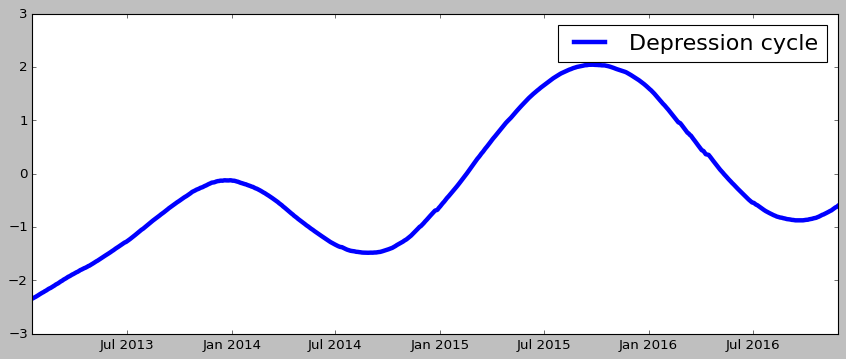

In [184]:
LOW = 365 * 1.5 # Days in 1.5 years
HIGH = 365 * 8 # Days in 8 years
K = 365 * 3 # Days in 3 years

# Remove K-samples from start and end dates
shortned_dates = dfUS["date"][K:-K]

bk_cycles = sm.tsa.filters.bkfilter(dfUS["Depression"], low=LOW, high=HIGH, K=K)

plt.figure(figsize=(13,5))
plt.plot(shortned_dates, bk_cycles, label="Depression cycle", linewidth=4)
plt.legend(loc="upper right", fontsize=20)
plt.show()

## Christiano Fitzgerald asymmetric, random walk filter

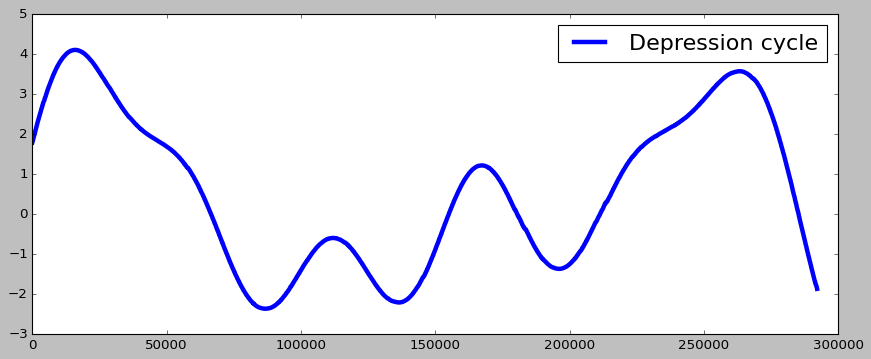

In [185]:
cf_cycles, cf_trend = sm.tsa.filters.cffilter(dfUS["Depression"], low=LOW, high=HIGH)

plt.figure(figsize=(13,5))
plt.plot(cf_cycles, label="Depression cycle", linewidth=4)
plt.legend(loc="upper right", fontsize=20)
plt.show()

## Hodrick-Prescott (HP) filter

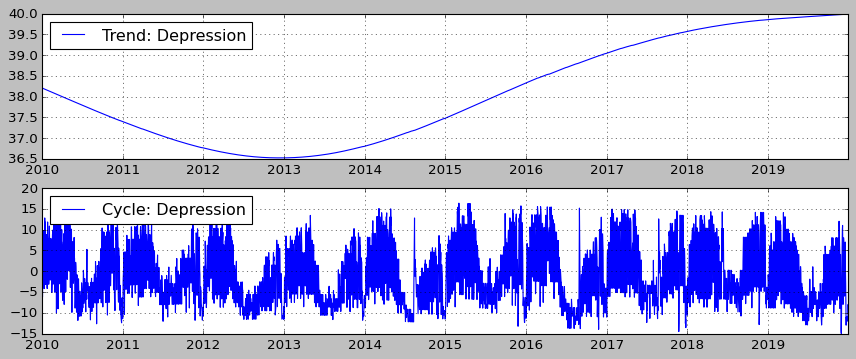

In [187]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_cycles.html
lamb = 1600*(365/4)**4

hp_cycle, hp_trend = sm.tsa.filters.hpfilter(dfUS["Depression"], lamb=lamb)


fig, axes = plt.subplots(2, figsize=(13,5));

axes[0].plot(dfUS["date"], hp_trend, label="Trend: Depression")
axes[0].legend(loc='upper left')
axes[0].grid()

axes[1].plot(dfUS["date"], hp_cycle, label="Cycle: Depression")
axes[1].legend(loc='upper left')
axes[1].grid()